In [1]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [1]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

# os
import os
import path

import random
import numpy as np 

# transformations
# import transform as T
from randaugment import RandAugmentMC

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

In [2]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [4]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95 #! 0.95 in the paper
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001

In [5]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)

        return x

In [6]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean+= torch.mean(images, dim=[0,2,3])
        std+= torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.4913966  0.48215377 0.44651437], std: [0.246344   0.24280126 0.26067406]
Files already downloaded and verified


In [7]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## III. Semi-Supervised Learning: Fixmatch

### III.1 Fixmatch on 10% train data

In [19]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 300
SUBSET_PROP = 0.10

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [20]:
# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
    

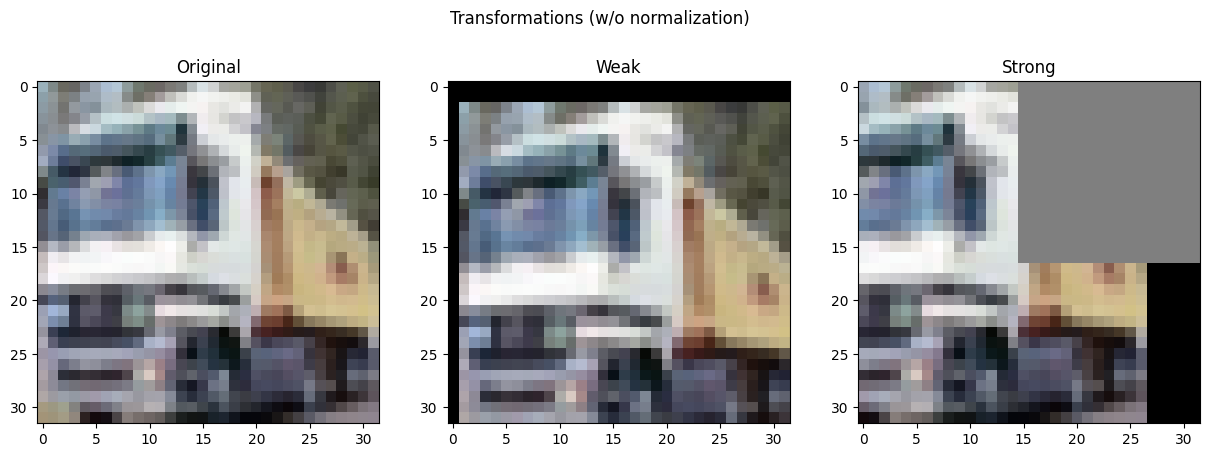

In [21]:
# plot original image, weak transform and strong transform on the same row
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(trainset[1][0].permute(1, 2, 0))
axs[0].set_title('Original')
axs[1].imshow(weak_transform(trainset[1][0]).permute(1, 2, 0)*std + mean)
axs[1].set_title('Weak')
axs[2].imshow(strong_transform(trainset[1][0]).permute(1, 2, 0)*std + mean)
axs[2].set_title('Strong')

plt.suptitle('Transformations (w/o normalization)')
plt.show()


In [24]:
def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb >= TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

In [25]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [26]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": torch.mean(max_qb).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)


Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 23.69%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 35.23%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 36.78%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 37.31%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 41.38%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 49.12%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.82%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.09%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.95%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.84%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 50.88%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.26%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.55%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.64%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.65%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.22%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.19%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.85%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.0%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.14%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.53%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.27%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.71%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.85%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.83%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.68%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.09%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.91%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.04%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.59%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.42%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.76%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.45%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.43%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.68%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.63%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.1%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.59%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.29%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.39%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.08%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.25%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.04%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.61%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.11%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.25%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.76%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.6%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.9%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.8%


Epoch    50:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.24%


Epoch    51:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.02%


Epoch    52:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.17%


Epoch    53:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.38%


Epoch    54:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.27%


Epoch    55:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.22%


Epoch    56:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.39%


Epoch    57:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.58%


Epoch    58:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.72%


Epoch    59:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.99%


Epoch    60:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.78%


Epoch    61:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.18%


Epoch    62:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.05%


Epoch    63:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.49%


Epoch    64:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.33%


Epoch    65:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.03%


Epoch    66:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.89%


Epoch    67:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.67%


Epoch    68:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.96%


Epoch    69:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.8%


Epoch    70:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.12%


Epoch    71:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.68%


Epoch    72:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.07%


Epoch    73:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.35%


Epoch    74:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.92%


Epoch    75:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.91%


Epoch    76:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.22%


Epoch    77:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.81%


Epoch    78:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.61%


Epoch    79:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.03%


Epoch    80:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.21%


Epoch    81:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.73%


Epoch    82:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.72%


Epoch    83:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.38%


Epoch    84:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.62%


Epoch    85:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.01%


Epoch    86:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.88%


Epoch    87:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.37%


Epoch    88:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.33%


Epoch    89:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.56%


Epoch    90:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.7%


Epoch    91:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.33%


Epoch    92:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.28%


Epoch    93:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.67%


Epoch    94:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.33%


Epoch    95:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.49%


Epoch    96:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.06%


Epoch    97:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.76%


Epoch    98:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.96%


Epoch    99:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.0%


Epoch   100:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.98%


Epoch   101:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.43%


Epoch   102:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.94%


Epoch   103:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.95%


Epoch   104:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.9%


Epoch   105:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.08%


Epoch   106:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.48%


Epoch   107:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.56%


Epoch   108:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.85%


Epoch   109:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.6%


Epoch   110:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.16%


Epoch   111:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.84%


Epoch   112:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.9%


Epoch   113:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.72%


Epoch   114:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.76%


Epoch   115:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.97%


Epoch   116:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.6%


Epoch   117:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.92%


Epoch   118:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.19%


Epoch   119:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.15%


Epoch   120:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.31%


Epoch   121:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.17%


Epoch   122:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.48%


Epoch   123:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.72%


Epoch   124:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.14%


Epoch   125:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.9%


Epoch   126:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.07%


Epoch   127:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.41%


Epoch   128:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.07%


Epoch   129:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.06%


Epoch   130:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.27%


Epoch   131:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.44%


Epoch   132:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.33%


Epoch   133:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.28%


Epoch   134:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.65%


Epoch   135:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.9%


Epoch   136:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.06%


Epoch   137:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.99%


Epoch   138:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.17%


Epoch   139:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.36%


Epoch   140:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.43%


Epoch   141:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.92%


Epoch   142:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.82%


Epoch   143:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.36%


Epoch   144:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.74%


Epoch   145:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.43%


Epoch   146:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.2%


Epoch   147:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.17%


Epoch   148:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.63%


Epoch   149:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.52%


Epoch   150:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.94%


Epoch   151:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.27%


Epoch   152:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.79%


Epoch   153:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.04%


Epoch   154:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.82%


Epoch   155:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.14%


Epoch   156:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.67%


Epoch   157:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.55%


Epoch   158:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.16%


Epoch   159:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.79%


Epoch   160:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.21%


Epoch   161:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.89%


Epoch   162:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.42%


Epoch   163:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.81%


Epoch   164:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.02%


Epoch   165:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.08%


Epoch   166:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.99%


Epoch   167:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.35%


Epoch   168:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.65%


Epoch   169:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.63%


Epoch   170:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.32%


Epoch   171:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.5%


Epoch   172:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.86%


Epoch   173:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.26%


Epoch   174:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.26%


Epoch   175:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.7%


Epoch   176:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.36%


Epoch   177:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.92%


Epoch   178:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.44%


Epoch   179:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.04%


Epoch   180:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.53%


Epoch   181:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.58%


Epoch   182:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.86%


Epoch   183:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.02%


Epoch   184:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.93%


Epoch   185:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.24%


Epoch   186:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.9%


Epoch   187:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.33%


Epoch   188:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.37%


Epoch   189:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.93%


Epoch   190:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.75%


Epoch   191:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.32%


Epoch   192:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.9%


Epoch   193:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.4%


Epoch   194:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.73%


Epoch   195:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.23%


Epoch   196:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.7%


Epoch   197:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.73%


Epoch   198:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.14%


Epoch   199:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.96%


Epoch   200:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.11%


Epoch   201:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.0%


Epoch   202:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.06%


Epoch   203:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.86%


Epoch   204:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.21%


Epoch   205:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.79%


Epoch   206:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.1%


Epoch   207:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.35%


Epoch   208:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.1%


Epoch   209:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.11%


Epoch   210:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.17%


Epoch   211:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.25%


Epoch   212:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.77%


Epoch   213:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.56%


Epoch   214:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.84%


Epoch   215:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.06%


Epoch   216:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.52%


Epoch   217:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.78%


Epoch   218:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.01%


Epoch   219:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.67%


Epoch   220:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.5%


Epoch   221:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.52%


Epoch   222:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.52%


Epoch   223:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.44%


Epoch   224:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.5%


Epoch   225:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.3%


Epoch   226:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.75%


Epoch   227:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.78%


Epoch   228:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.6%


Epoch   229:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.39%


Epoch   230:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.01%


Epoch   231:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.72%


Epoch   232:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.82%


Epoch   233:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   234:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.99%


Epoch   235:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   236:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.98%


Epoch   237:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.53%


Epoch   238:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.46%


Epoch   239:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.98%


Epoch   240:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.76%


Epoch   241:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.11%


Epoch   242:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.78%


Epoch   243:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.91%


Epoch   244:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.87%


Epoch   245:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.81%


Epoch   246:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.17%


Epoch   247:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.05%


Epoch   248:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.87%


Epoch   249:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.97%


Epoch   250:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.3%


Epoch   251:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.31%


Epoch   252:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.93%


Epoch   253:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.47%


Epoch   254:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.13%


Epoch   255:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.25%


Epoch   256:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.22%


Epoch   257:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.54%


Epoch   258:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.42%


Epoch   259:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.47%


Epoch   260:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.2%


Epoch   261:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.42%


Epoch   262:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.94%


Epoch   263:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.24%


Epoch   264:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.29%


Epoch   265:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.23%


Epoch   266:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.05%


Epoch   267:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.07%


Epoch   268:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.16%


Epoch   269:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.29%


Epoch   270:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.32%


Epoch   271:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.17%


Epoch   272:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.24%


Epoch   273:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.49%


Epoch   274:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.44%


Epoch   275:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.51%


Epoch   276:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.15%


Epoch   277:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.35%


Epoch   278:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.56%


Epoch   279:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.5%


Epoch   280:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.44%


Epoch   281:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.25%


Epoch   282:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.37%


Epoch   283:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.33%


Epoch   284:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.38%


Epoch   285:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.3%


Epoch   286:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.36%


Epoch   287:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.4%


Epoch   288:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.38%


Epoch   289:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.3%


Epoch   290:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.34%


Epoch   291:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.33%


Epoch   292:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.26%


Epoch   293:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.28%


Epoch   294:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.33%


Epoch   295:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.31%


Epoch   296:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.33%


Epoch   297:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.34%


Epoch   298:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.32%


Epoch   299:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.29%


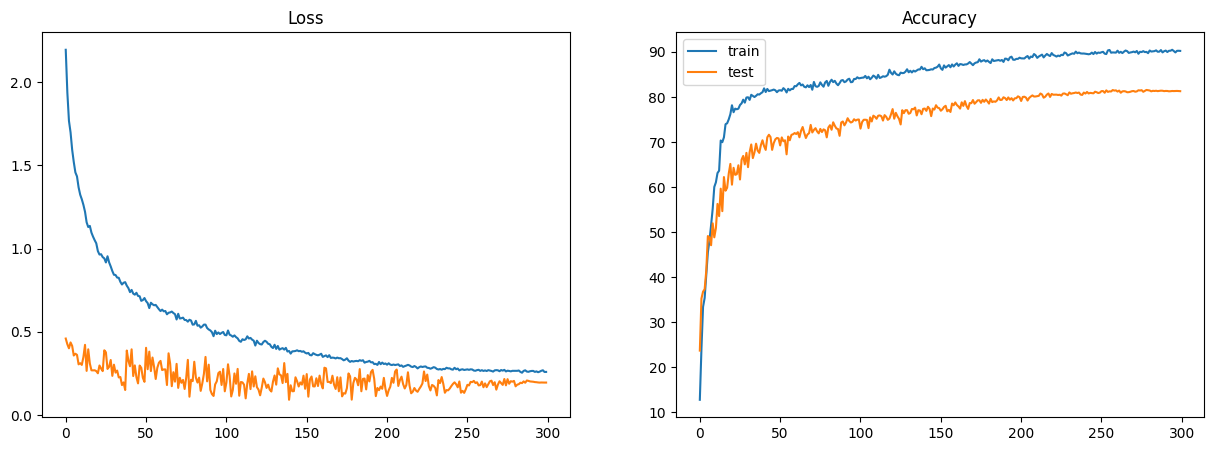

In [27]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_10_losses_accuracies.png")

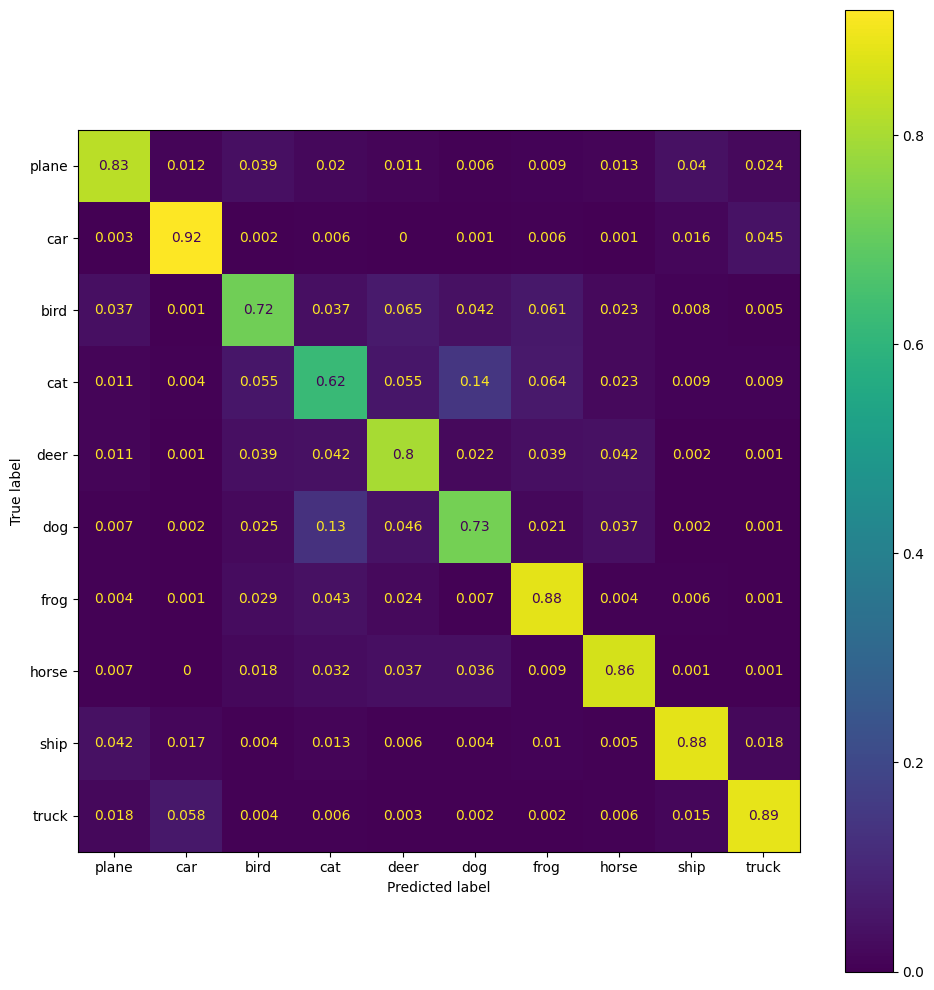

In [28]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_10_confusion_matrix.png")

Test Accuracy: 81.29%


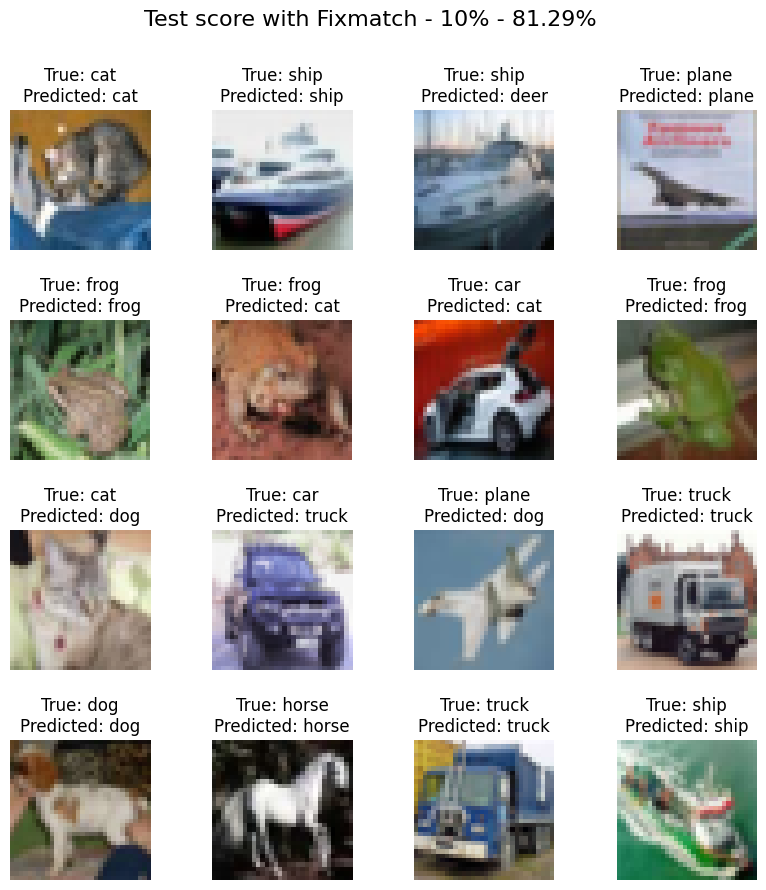

In [29]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_10_fixmatch.png")

### III.2 Fixmatch on 5% train data

In [14]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 300
SUBSET_PROP = 0.05

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
    

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [15]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": torch.mean(max_qb).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)


Start training


Epoch     0:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 21.26%


Epoch     1:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 25.09%


Epoch     2:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 17.36%


Epoch     3:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 34.23%


Epoch     4:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 28.19%


Epoch     5:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 33.59%


Epoch     6:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.39%


Epoch     7:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 38.61%


Epoch     8:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.5%


Epoch     9:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.42%


Epoch    10:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 36.26%


Epoch    11:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.92%


Epoch    12:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 43.98%


Epoch    13:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.94%


Epoch    14:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.83%


Epoch    15:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.26%


Epoch    16:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.69%


Epoch    17:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.1%


Epoch    18:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.72%


Epoch    19:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 52.44%


Epoch    20:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.55%


Epoch    21:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 52.3%


Epoch    22:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.51%


Epoch    23:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.05%


Epoch    24:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.13%


Epoch    25:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.85%


Epoch    26:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.77%


Epoch    27:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.13%


Epoch    28:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.58%


Epoch    29:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.16%


Epoch    30:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.11%


Epoch    31:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.89%


Epoch    32:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.39%


Epoch    33:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.43%


Epoch    34:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.12%


Epoch    35:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.44%


Epoch    36:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.45%


Epoch    37:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.88%


Epoch    38:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.97%


Epoch    39:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.06%


Epoch    40:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.89%


Epoch    41:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.98%


Epoch    42:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.53%


Epoch    43:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.59%


Epoch    44:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.23%


Epoch    45:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.0%


Epoch    46:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.74%


Epoch    47:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.46%


Epoch    48:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.64%


Epoch    49:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.77%


Epoch    50:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.62%


Epoch    51:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.34%


Epoch    52:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.81%


Epoch    53:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.99%


Epoch    54:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.99%


Epoch    55:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.4%


Epoch    56:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.2%


Epoch    57:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.26%


Epoch    58:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.21%


Epoch    59:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.94%


Epoch    60:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.73%


Epoch    61:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.97%


Epoch    62:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.82%


Epoch    63:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.84%


Epoch    64:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.94%


Epoch    65:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.9%


Epoch    66:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.9%


Epoch    67:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.13%


Epoch    68:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.96%


Epoch    69:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.65%


Epoch    70:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.12%


Epoch    71:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.12%


Epoch    72:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.73%


Epoch    73:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.91%


Epoch    74:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.41%


Epoch    75:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.87%


Epoch    76:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.81%


Epoch    77:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.06%


Epoch    78:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.66%


Epoch    79:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.68%


Epoch    80:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.17%


Epoch    81:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.11%


Epoch    82:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.02%


Epoch    83:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.03%


Epoch    84:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.11%


Epoch    85:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.05%


Epoch    86:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.8%


Epoch    87:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.96%


Epoch    88:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.61%


Epoch    89:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.78%


Epoch    90:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.56%


Epoch    91:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.0%


Epoch    92:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.03%


Epoch    93:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.2%


Epoch    94:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.16%


Epoch    95:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.67%


Epoch    96:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.55%


Epoch    97:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.67%


Epoch    98:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.56%


Epoch    99:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.37%


Epoch   100:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.04%


Epoch   101:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.19%


Epoch   102:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.9%


Epoch   103:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.59%


Epoch   104:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.92%


Epoch   105:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.13%


Epoch   106:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.19%


Epoch   107:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.58%


Epoch   108:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.25%


Epoch   109:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.83%


Epoch   110:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.78%


Epoch   111:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.33%


Epoch   112:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.16%


Epoch   113:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.58%


Epoch   114:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.88%


Epoch   115:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.76%


Epoch   116:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.6%


Epoch   117:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.78%


Epoch   118:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.9%


Epoch   119:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.01%


Epoch   120:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.24%


Epoch   121:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.6%


Epoch   122:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.09%


Epoch   123:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.94%


Epoch   124:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.72%


Epoch   125:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.56%


Epoch   126:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.18%


Epoch   127:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.25%


Epoch   128:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.68%


Epoch   129:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.93%


Epoch   130:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.79%


Epoch   131:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.09%


Epoch   132:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.29%


Epoch   133:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.31%


Epoch   134:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.32%


Epoch   135:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.62%


Epoch   136:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.96%


Epoch   137:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.24%


Epoch   138:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.23%


Epoch   139:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.76%


Epoch   140:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.95%


Epoch   141:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.53%


Epoch   142:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.24%


Epoch   143:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.83%


Epoch   144:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.64%


Epoch   145:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.91%


Epoch   146:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.7%


Epoch   147:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.01%


Epoch   148:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.57%


Epoch   149:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.03%


Epoch   150:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.31%


Epoch   151:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.62%


Epoch   152:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.69%


Epoch   153:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.52%


Epoch   154:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.62%


Epoch   155:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.31%


Epoch   156:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.33%


Epoch   157:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.06%


Epoch   158:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.77%


Epoch   159:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.88%


Epoch   160:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.62%


Epoch   161:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.24%


Epoch   162:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.87%


Epoch   163:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.98%


Epoch   164:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.46%


Epoch   165:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.29%


Epoch   166:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.75%


Epoch   167:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.76%


Epoch   168:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.52%


Epoch   169:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.83%


Epoch   170:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.32%


Epoch   171:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.64%


Epoch   172:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.51%


Epoch   173:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.29%


Epoch   174:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.89%


Epoch   175:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.05%


Epoch   176:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.48%


Epoch   177:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.99%


Epoch   178:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.45%


Epoch   179:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.44%


Epoch   180:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.68%


Epoch   181:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.87%


Epoch   182:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.23%


Epoch   183:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.56%


Epoch   184:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.18%


Epoch   185:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.0%


Epoch   186:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.01%


Epoch   187:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.6%


Epoch   188:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.23%


Epoch   189:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.5%


Epoch   190:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.28%


Epoch   191:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.59%


Epoch   192:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.6%


Epoch   193:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.24%


Epoch   194:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.36%


Epoch   195:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.4%


Epoch   196:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.93%


Epoch   197:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.21%


Epoch   198:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.34%


Epoch   199:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.36%


Epoch   200:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.5%


Epoch   201:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.13%


Epoch   202:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.77%


Epoch   203:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.64%


Epoch   204:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.19%


Epoch   205:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.81%


Epoch   206:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.76%


Epoch   207:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.16%


Epoch   208:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.97%


Epoch   209:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.53%


Epoch   210:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.07%


Epoch   211:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.35%


Epoch   212:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.63%


Epoch   213:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.34%


Epoch   214:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.52%


Epoch   215:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.54%


Epoch   216:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.83%


Epoch   217:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.19%


Epoch   218:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.05%


Epoch   219:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.63%


Epoch   220:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.65%


Epoch   221:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.93%


Epoch   222:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.26%


Epoch   223:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.1%


Epoch   224:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.38%


Epoch   225:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.39%


Epoch   226:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.18%


Epoch   227:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.07%


Epoch   228:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.26%


Epoch   229:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.98%


Epoch   230:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.16%


Epoch   231:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.55%


Epoch   232:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.7%


Epoch   233:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.42%


Epoch   234:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.58%


Epoch   235:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.17%


Epoch   236:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.63%


Epoch   237:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.98%


Epoch   238:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.13%


Epoch   239:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.71%


Epoch   240:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.28%


Epoch   241:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.64%


Epoch   242:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.36%


Epoch   243:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.35%


Epoch   244:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.63%


Epoch   245:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.55%


Epoch   246:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.63%


Epoch   247:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.54%


Epoch   248:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.68%


Epoch   249:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.41%


Epoch   250:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.57%


Epoch   251:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.76%


Epoch   252:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.59%


Epoch   253:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.48%


Epoch   254:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.78%


Epoch   255:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.92%


Epoch   256:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.95%


Epoch   257:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.54%


Epoch   258:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.78%


Epoch   259:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.07%


Epoch   260:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.86%


Epoch   261:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.68%


Epoch   262:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.81%


Epoch   263:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.76%


Epoch   264:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.68%


Epoch   265:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.74%


Epoch   266:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.77%


Epoch   267:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.86%


Epoch   268:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.75%


Epoch   269:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.63%


Epoch   270:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.8%


Epoch   271:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.62%


Epoch   272:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.82%


Epoch   273:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.86%


Epoch   274:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.98%


Epoch   275:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.8%


Epoch   276:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.21%


Epoch   277:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.03%


Epoch   278:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.95%


Epoch   279:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.07%


Epoch   280:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   281:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.78%


Epoch   282:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   283:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.01%


Epoch   284:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.82%


Epoch   285:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.83%


Epoch   286:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.98%


Epoch   287:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.77%


Epoch   288:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.85%


Epoch   289:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.88%


Epoch   290:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.9%


Epoch   291:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.85%


Epoch   292:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.82%


Epoch   293:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.94%


Epoch   294:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.9%


Epoch   295:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   296:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   297:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.91%


Epoch   298:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.92%


Epoch   299:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.91%


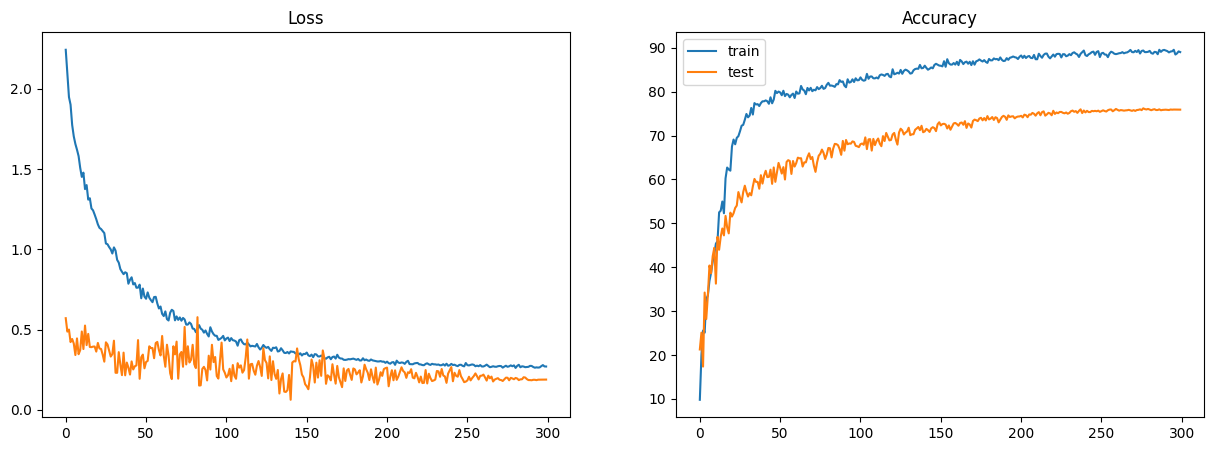

In [16]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_5_losses_accuracies.png")

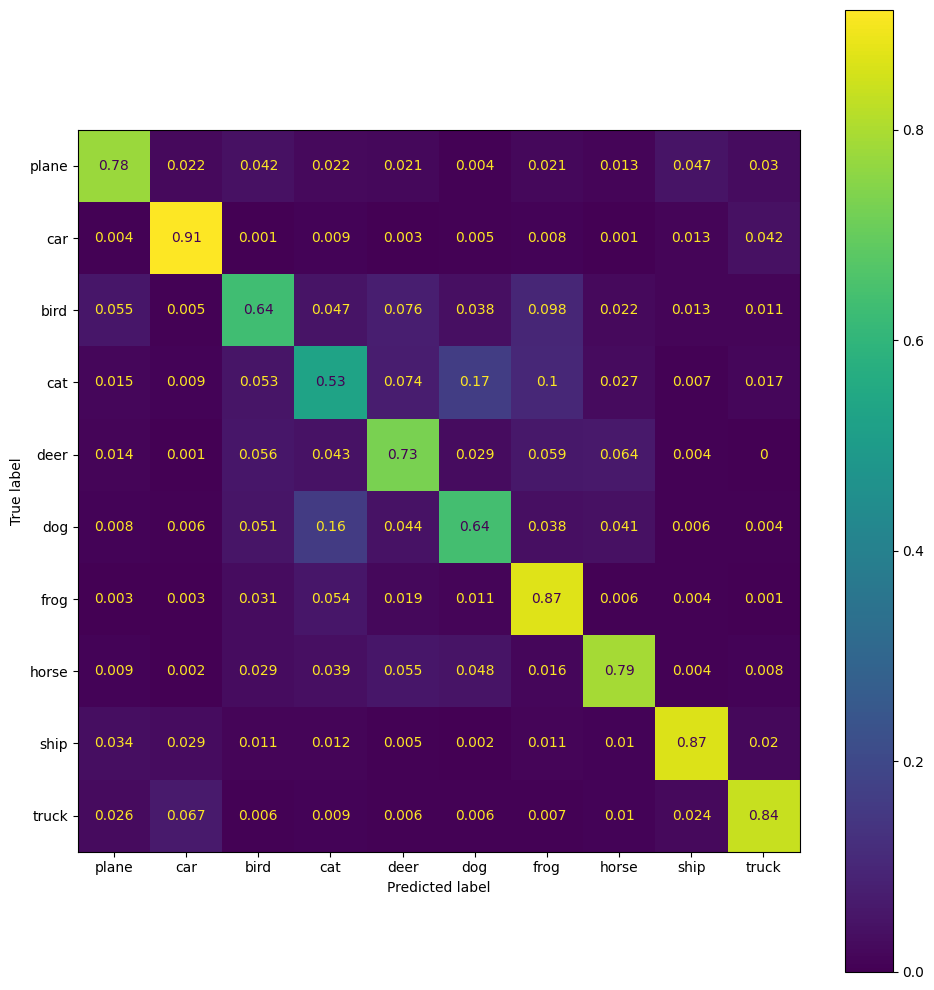

In [17]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_5_confusion_matrix.png")

Test Accuracy: 75.91%


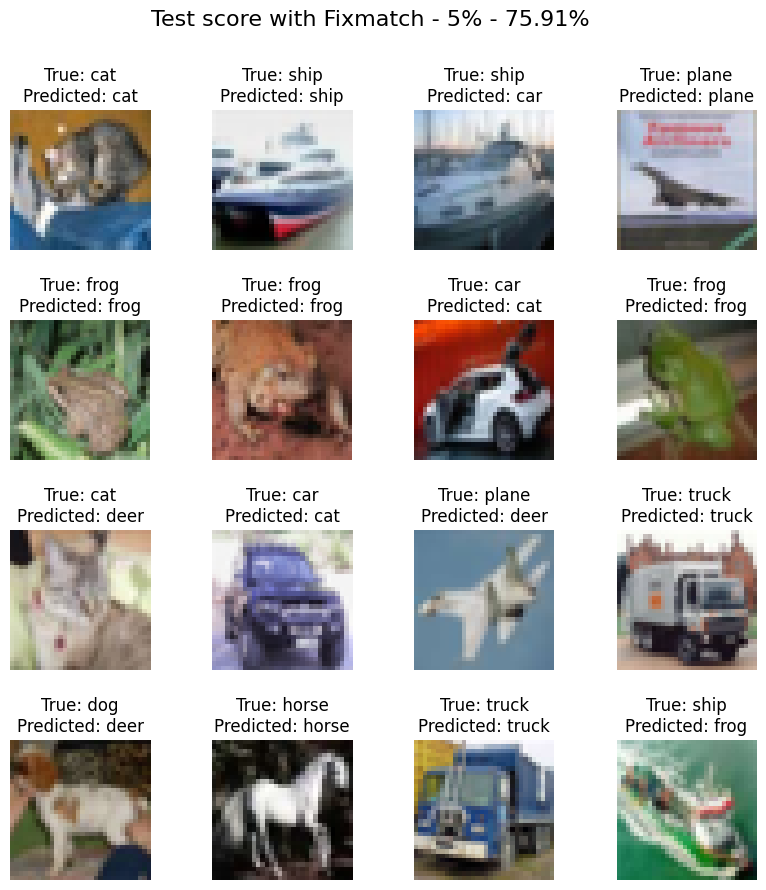

In [18]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_5_fixmatch.png")

### III.3 Fixmatch on 1% train data

In [8]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 300
SUBSET_PROP = 0.01

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
    

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb >= TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [9]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": torch.mean(max_qb).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)


Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.13%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 14.53%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 20.09%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 18.54%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 22.17%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 23.76%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 23.66%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 24.23%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.23%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.3%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.01%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.02%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.52%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.12%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.45%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.94%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.8%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.69%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.57%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.65%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.18%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.63%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.32%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.43%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.12%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.39%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.54%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.31%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.65%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.86%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.92%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.03%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.67%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.63%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.29%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.31%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.81%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.42%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.21%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.84%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.08%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.15%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.31%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.05%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.43%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.66%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.98%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.29%


Epoch    50:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.07%


Epoch    51:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.32%


Epoch    52:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.01%


Epoch    53:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.75%


Epoch    54:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.51%


Epoch    55:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.86%


Epoch    56:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.52%


Epoch    57:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.49%


Epoch    58:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.63%


Epoch    59:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.12%


Epoch    60:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.09%


Epoch    61:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.86%


Epoch    62:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.46%


Epoch    63:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.27%


Epoch    64:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.07%


Epoch    65:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.04%


Epoch    66:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.77%


Epoch    67:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.81%


Epoch    68:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.2%


Epoch    69:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.73%


Epoch    70:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.04%


Epoch    71:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.27%


Epoch    72:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.62%


Epoch    73:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.85%


Epoch    74:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.07%


Epoch    75:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.68%


Epoch    76:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.63%


Epoch    77:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.09%


Epoch    78:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.52%


Epoch    79:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.57%


Epoch    80:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.09%


Epoch    81:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.78%


Epoch    82:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.53%


Epoch    83:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.46%


Epoch    84:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.34%


Epoch    85:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.1%


Epoch    86:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.32%


Epoch    87:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.37%


Epoch    88:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.77%


Epoch    89:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.97%


Epoch    90:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.6%


Epoch    91:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.06%


Epoch    92:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.87%


Epoch    93:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.72%


Epoch    94:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.27%


Epoch    95:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.85%


Epoch    96:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.71%


Epoch    97:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.55%


Epoch    98:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.5%


Epoch    99:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.4%


Epoch   100:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.72%


Epoch   101:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.79%


Epoch   102:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.13%


Epoch   103:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.92%


Epoch   104:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.92%


Epoch   105:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.63%


Epoch   106:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.46%


Epoch   107:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.93%


Epoch   108:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.83%


Epoch   109:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.95%


Epoch   110:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.66%


Epoch   111:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.22%


Epoch   112:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.08%


Epoch   113:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.87%


Epoch   114:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.31%


Epoch   115:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.15%


Epoch   116:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.64%


Epoch   117:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.76%


Epoch   118:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.4%


Epoch   119:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.95%


Epoch   120:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.02%


Epoch   121:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.24%


Epoch   122:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.19%


Epoch   123:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.92%


Epoch   124:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.95%


Epoch   125:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.62%


Epoch   126:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.89%


Epoch   127:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.66%


Epoch   128:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.99%


Epoch   129:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.2%


Epoch   130:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.11%


Epoch   131:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.67%


Epoch   132:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.87%


Epoch   133:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.53%


Epoch   134:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.65%


Epoch   135:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.64%


Epoch   136:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.72%


Epoch   137:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.33%


Epoch   138:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.42%


Epoch   139:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.07%


Epoch   140:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.15%


Epoch   141:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.29%


Epoch   142:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.46%


Epoch   143:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.41%


Epoch   144:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.89%


Epoch   145:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.43%


Epoch   146:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.98%


Epoch   147:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.42%


Epoch   148:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.65%


Epoch   149:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.22%


Epoch   150:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.5%


Epoch   151:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.03%


Epoch   152:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.65%


Epoch   153:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.31%


Epoch   154:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.14%


Epoch   155:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.08%


Epoch   156:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.91%


Epoch   157:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.31%


Epoch   158:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.99%


Epoch   159:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.77%


Epoch   160:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.02%


Epoch   161:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.12%


Epoch   162:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.41%


Epoch   163:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.99%


Epoch   164:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.9%


Epoch   165:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.28%


Epoch   166:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.5%


Epoch   167:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.21%


Epoch   168:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.83%


Epoch   169:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.84%


Epoch   170:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.59%


Epoch   171:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.59%


Epoch   172:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.79%


Epoch   173:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.98%


Epoch   174:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.74%


Epoch   175:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.54%


Epoch   176:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.07%


Epoch   177:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.08%


Epoch   178:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.69%


Epoch   179:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.59%


Epoch   180:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.71%


Epoch   181:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.38%


Epoch   182:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.39%


Epoch   183:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.17%


Epoch   184:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.65%


Epoch   185:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.29%


Epoch   186:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.64%


Epoch   187:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.0%


Epoch   188:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.21%


Epoch   189:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.67%


Epoch   190:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.07%


Epoch   191:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.2%


Epoch   192:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.39%


Epoch   193:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.32%


Epoch   194:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.53%


Epoch   195:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.56%


Epoch   196:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.99%


Epoch   197:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.6%


Epoch   198:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.18%


Epoch   199:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.12%


Epoch   200:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.79%


Epoch   201:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.39%


Epoch   202:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.4%


Epoch   203:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.74%


Epoch   204:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.87%


Epoch   205:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.89%


Epoch   206:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.11%


Epoch   207:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.62%


Epoch   208:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.88%


Epoch   209:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.71%


Epoch   210:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.16%


Epoch   211:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.18%


Epoch   212:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.11%


Epoch   213:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.25%


Epoch   214:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.46%


Epoch   215:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.62%


Epoch   216:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.25%


Epoch   217:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.67%


Epoch   218:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.14%


Epoch   219:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.54%


Epoch   220:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.14%


Epoch   221:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.41%


Epoch   222:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.14%


Epoch   223:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.89%


Epoch   224:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.37%


Epoch   225:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.44%


Epoch   226:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.79%


Epoch   227:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.67%


Epoch   228:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.74%


Epoch   229:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.54%


Epoch   230:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.52%


Epoch   231:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.51%


Epoch   232:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.25%


Epoch   233:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.22%


Epoch   234:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.78%


Epoch   235:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.52%


Epoch   236:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.89%


Epoch   237:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.62%


Epoch   238:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


Epoch   239:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.71%


Epoch   240:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.59%


Epoch   241:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.23%


Epoch   242:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.48%


Epoch   243:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.61%


Epoch   244:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.66%


Epoch   245:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.35%


Epoch   246:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.22%


Epoch   247:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.33%


Epoch   248:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.49%


Epoch   249:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.34%


Epoch   250:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.57%


Epoch   251:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.47%


Epoch   252:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.58%


Epoch   253:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.54%


Epoch   254:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.42%


Epoch   255:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.54%


Epoch   256:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.54%


Epoch   257:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.69%


Epoch   258:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.62%


Epoch   259:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.62%


Epoch   260:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.48%


Epoch   261:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.61%


Epoch   262:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.62%


Epoch   263:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.51%


Epoch   264:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.59%


Epoch   265:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.46%


Epoch   266:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.59%


Epoch   267:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.51%


Epoch   268:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.65%


Epoch   269:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.78%


Epoch   270:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.78%


Epoch   271:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.67%


Epoch   272:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.87%


Epoch   273:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.94%


Epoch   274:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.94%


Epoch   275:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.9%


Epoch   276:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.95%


Epoch   277:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.88%


Epoch   278:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.77%


Epoch   279:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.79%


Epoch   280:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.74%


Epoch   281:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.64%


Epoch   282:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.71%


Epoch   283:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.68%


Epoch   284:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


Epoch   285:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.77%


Epoch   286:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


Epoch   287:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.79%


Epoch   288:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.78%


Epoch   289:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


Epoch   290:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.72%


Epoch   291:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.69%


Epoch   292:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.69%


Epoch   293:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.75%


Epoch   294:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


Epoch   295:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.77%


Epoch   296:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


Epoch   297:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.75%


Epoch   298:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.75%


Epoch   299:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


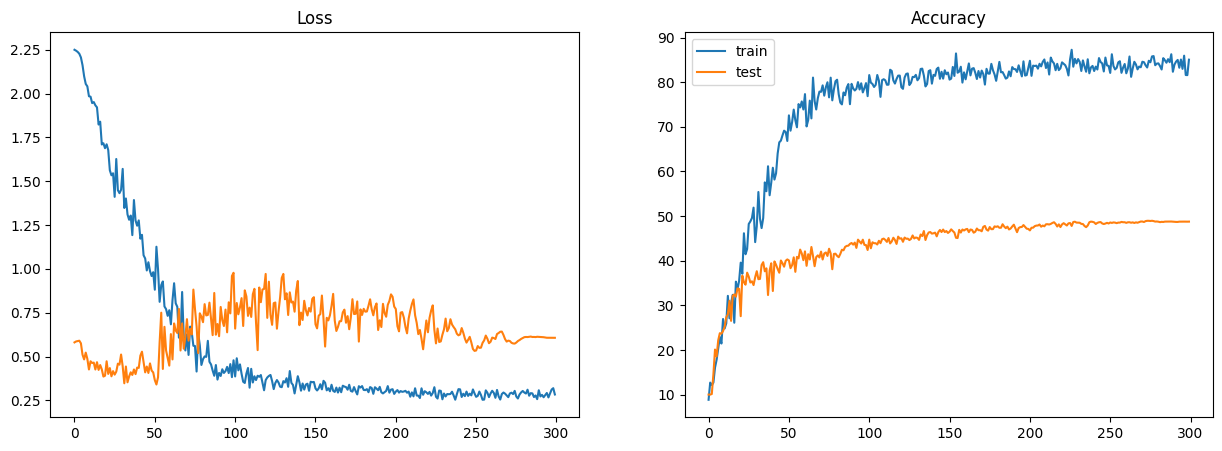

In [10]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_1_losses_accuracies.png")

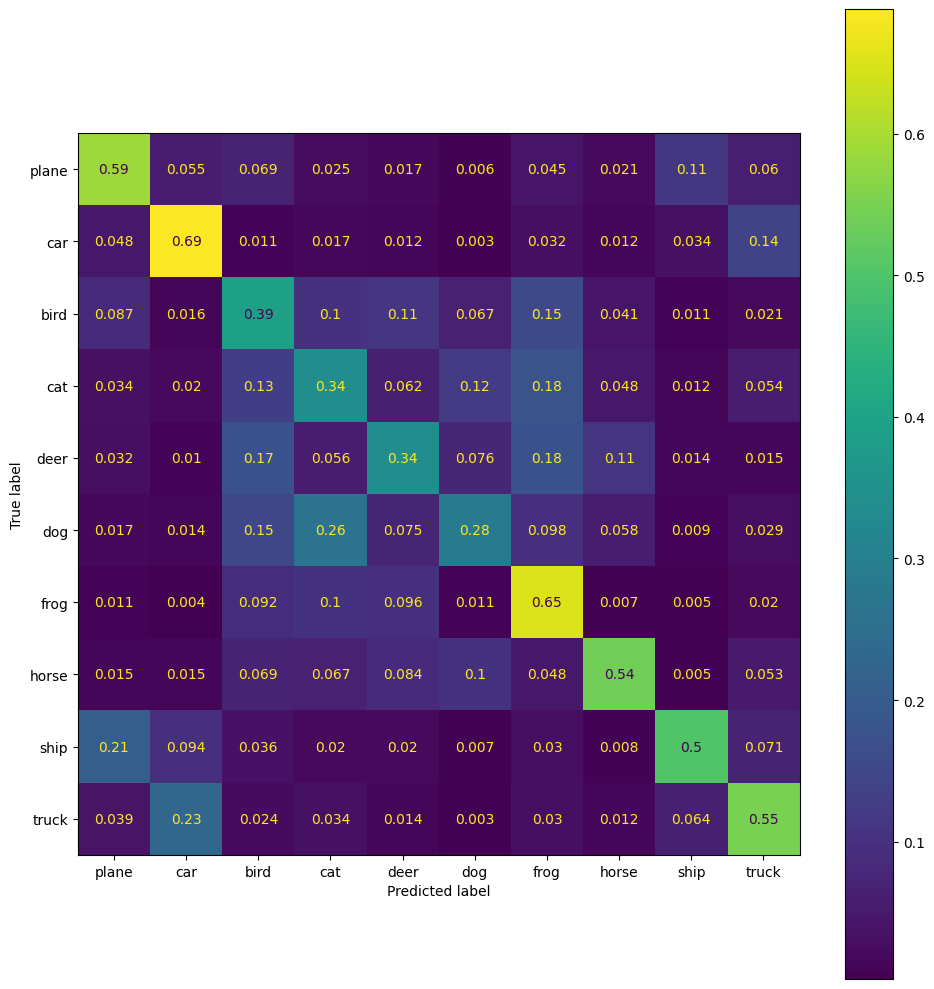

In [11]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_1_confusion_matrix.png")

Test Accuracy: 48.76%


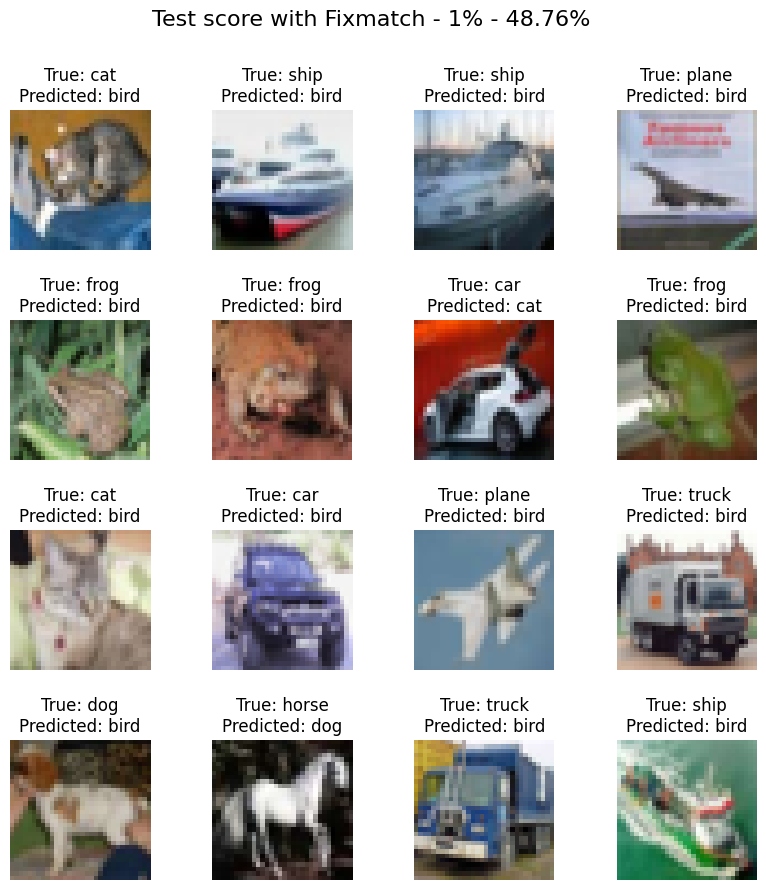

In [12]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_1_fixmatch.png")